<a href="https://colab.research.google.com/github/jraval/DS-Unit-2-Kaggle-Challenge/blob/master/JAY_RAVAL_LS_DSPT9_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [26]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [27]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [28]:
# Import necessary modules
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix

In [29]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


In [30]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [33]:
#Make pipeline!
pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate=False),
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

#Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred ))

Validation Accuracy 0.8140409527789386


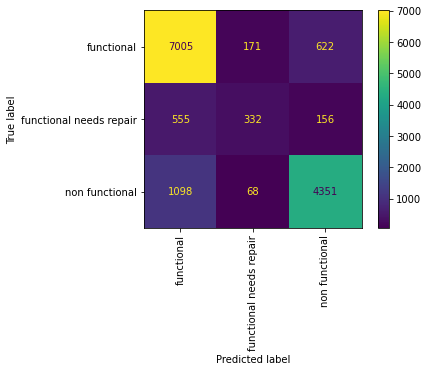

In [41]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

## **How many correct predictions were made? Total Predictions? Classification Accuracy?**

In [43]:
correct_predictions = 7005 + 4351 + 332
correct_predictions

11688

In [44]:
total_predictions = 7005 + 171 + 622 + 555 + 332 + 156 + 1098 + 68 + 4351
total_predictions

14358

In [45]:
correct_predictions/total_predictions#Manual accuracy score

0.8140409527789386

In [46]:
accuracy_score(y_val, y_pred)

0.8140409527789386

In [47]:
sum(y_pred == y_val)/ len(y_pred)

0.8140409527789386

# Use classification metrics: precision, recall

## Overview

In [34]:
pd.__version__

'1.1.4'

In [36]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [5]:
# Load the digits data

# The deafult with 10 classes (digits 0-9)
digits = datasets.load_digits(n_class=10)

# Create the feature matrix
X = digits.data

# Create the target array
y = digits.target

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Instantiate and train a decision tree classifier
dt_classifier = DecisionTreeClassifier().fit(X_train, y_train)

In [11]:
# Load modules
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Create the data (feature, target)
X, y = make_classification(n_samples=10000, n_features=5,
                          n_classes=2, n_informative=3,
                          random_state=42)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create and fit the model
logreg_classifier = LogisticRegression().fit(X_train, y_train)

Text(0.5, 1.0, 'Confusion Matrix: Digits decision tree model')

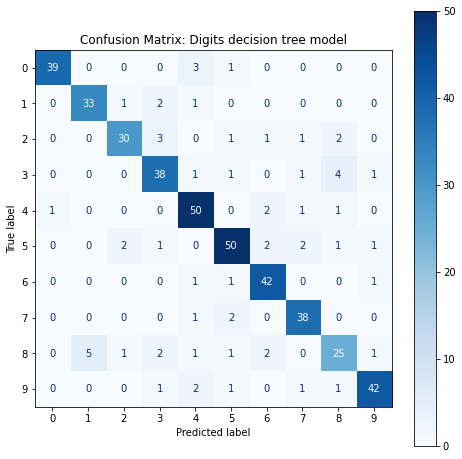

In [10]:
# Plot the decision matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(8,8))



plot_confusion_matrix(dt_classifier, X_test, y_test,
                                 display_labels=digits.target_names,
                                 cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: Digits decision tree model')

#fig.clf();

In [12]:
# The value of the 10th observation
print('The 10th observation: ', X_test[10:11])
# Print out the probability for the 10th observation
print('Predicted probability for the 10th observation: ',
      logreg_classifier.predict_proba(X_test)[10:11])
# Print the two classes
print('The two classes: ')
logreg_classifier.classes_

The 10th observation:  [[-0.73552378  1.05914888 -0.60278934 -0.32282208  0.55717004]]
Predicted probability for the 10th observation:  [[0.73592057 0.26407943]]
The two classes: 


array([0, 1])

In [14]:
# Check the class of the 10th observation
logreg_classifier.predict(X_test[10:11])

array([0])

In [17]:
# Load modules
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

# Create the data (feature, target)
X, y = make_classification(n_samples=10000, n_features=5,
                          n_classes=2, n_informative=3,
                          random_state=42)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create and fit the model
logreg_classifier = LogisticRegression().fit(X_train, y_train)
# Create predicted probabilities
y_pred_prob = logreg_classifier.predict_proba(X_test)[:,1]

In [18]:
# Create the data for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# See the results in a table
roccurve_df = pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

roccurve_df.head()

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.999969
1,0.000000,0.000786,0.999969
2,0.000000,0.291438,0.983222
3,0.000815,0.291438,0.983049
4,0.000815,0.360566,0.970583


Text(0, 0.5, 'True Positive Rate')

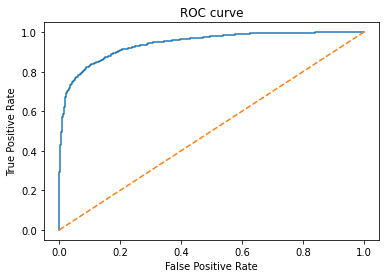

In [19]:
# Plot the ROC curve
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)
plt.plot([0,1], ls='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [20]:
# Calculate the area under the curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_prob)

0.9419681927513379